# Influence Functions

In [20]:
import os
import kagglehub
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import jax.scipy.linalg as linalg
from jax.flatten_util import ravel_pytree

from tqdm import tqdm


In [21]:
def load_mnist_kagglehub(num_train=500, num_test=50):
    # Download the dataset via kagglehub.
    dataset_path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
    print("Path to dataset files:", dataset_path)
    
    # Construct file paths.
    train_csv = os.path.join(dataset_path, "mnist_train.csv")
    test_csv = os.path.join(dataset_path, "mnist_test.csv")
    
    # Load CSV files using pandas.
    df_train = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv)
    
    # The training CSV should have a "label" column and the remaining 784 columns are pixel values.
    y_train = df_train["label"].values
    x_train = df_train.drop(columns=["label"]).values
    
    # Normalize pixel values (assumes pixel values are 0-255).
    x_train = x_train.astype("float32") / 255.0
    
    # For testing, if labels exist, process similarly.
    if "label" in df_test.columns:
        y_test = df_test["label"].values
        x_test = df_test.drop(columns=["label"]).values
    else:
        y_test = None
        x_test = df_test.values

    x_test = x_test.astype("float32") / 255.0

    # Return small subsets for demonstration.
    return jnp.array(x_train[:num_train]), jnp.array(y_train[:num_train]), jnp.array(x_test[:num_test]), jnp.array(y_test[:num_test]) if y_test is not None else None


In [22]:
class SimpleMLP(nn.Module):
    hidden_dim: int = 128
    output_dim: int = 10  # 10 classes for MNIST

    @nn.compact
    def __call__(self, x):
        # x is expected to be of shape (batch, 784)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def loss_fn(params, apply_fn, x, y):
    logits = apply_fn(params, x)  # directly call the function
    one_hot = jax.nn.one_hot(y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits, one_hot).mean()
    return loss

@jax.jit
def train_step(state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state.apply_fn, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [23]:
# Load MNIST data using kagglehub.
x_train, y_train, x_test, y_test = load_mnist_kagglehub(num_train=500, num_test=50)

Path to dataset files: /home/j/.cache/kagglehub/datasets/oddrationale/mnist-in-csv/versions/2


In [59]:


# Initialize model and training state.
key = jax.random.PRNGKey(0)
model = SimpleMLP()
dummy_input = jnp.ones((1, 784))
params = model.init(key, dummy_input)

tx = optax.adam(learning_rate=1e-3)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Train (or finetune) the network for a few epochs.
num_epochs = 10000
batch_size = 50
num_batches = x_train.shape[0] // batch_size
for epoch in range(num_epochs):
    perm = np.random.permutation(x_train.shape[0])
    for i in range(num_batches):
        idx = perm[i*batch_size:(i+1)*batch_size]
        state, loss = train_step(state, x_train[idx], y_train[idx])
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")



Epoch 1, Loss: 1.8073
Epoch 2, Loss: 1.0285
Epoch 3, Loss: 0.6739
Epoch 4, Loss: 0.5533
Epoch 5, Loss: 0.5271
Epoch 6, Loss: 0.3333
Epoch 7, Loss: 0.2506
Epoch 8, Loss: 0.2492
Epoch 9, Loss: 0.1542
Epoch 10, Loss: 0.1214
Epoch 11, Loss: 0.1350
Epoch 12, Loss: 0.1783
Epoch 13, Loss: 0.1188
Epoch 14, Loss: 0.1045
Epoch 15, Loss: 0.1100
Epoch 16, Loss: 0.0447
Epoch 17, Loss: 0.0597
Epoch 18, Loss: 0.0558
Epoch 19, Loss: 0.0588
Epoch 20, Loss: 0.0498
Epoch 21, Loss: 0.0474
Epoch 22, Loss: 0.0213
Epoch 23, Loss: 0.0230
Epoch 24, Loss: 0.0374
Epoch 25, Loss: 0.0242
Epoch 26, Loss: 0.0313
Epoch 27, Loss: 0.0269
Epoch 28, Loss: 0.0214
Epoch 29, Loss: 0.0164
Epoch 30, Loss: 0.0185
Epoch 31, Loss: 0.0171
Epoch 32, Loss: 0.0156
Epoch 33, Loss: 0.0111
Epoch 34, Loss: 0.0258
Epoch 35, Loss: 0.0189
Epoch 36, Loss: 0.0112
Epoch 37, Loss: 0.0134
Epoch 38, Loss: 0.0098
Epoch 39, Loss: 0.0150
Epoch 40, Loss: 0.0076
Epoch 41, Loss: 0.0094
Epoch 42, Loss: 0.0135
Epoch 43, Loss: 0.0108
Epoch 44, Loss: 0.00

In [46]:
import matplotlib.pyplot as plt

def plot_examples(x, y_true, y_pred, title, n_cols):
    """
    Plots a grid of MNIST images with their true and predicted labels.
    Correct predictions are shown with a green title, while incorrect ones are in red.
    
    Parameters:
    - x: Array of images (each row is a flattened 28x28 image)
    - y_true: True labels (array-like)
    - y_pred: Predicted labels (array-like)
    - title: Overall title for the plot
    - n_cols: Number of columns in the grid
    """
    n_cols=10
    n_images = x.shape[0]
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easy iteration if grid is 2D
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i in range(n_rows * n_cols):
        ax = axes[i]
        ax.axis("off")
        if i < n_images:
            # Reshape the flattened image into 28x28
            image = np.array(x[i]).reshape(28, 28)
            ax.imshow(image, cmap="gray")
            
            true_label = y_true[i]
            pred_label = y_pred[i]
            color = "green" if true_label == pred_label else "red"
            ax.set_title(f"T:{true_label}\nP:{pred_label}", color=color, fontsize=8)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()




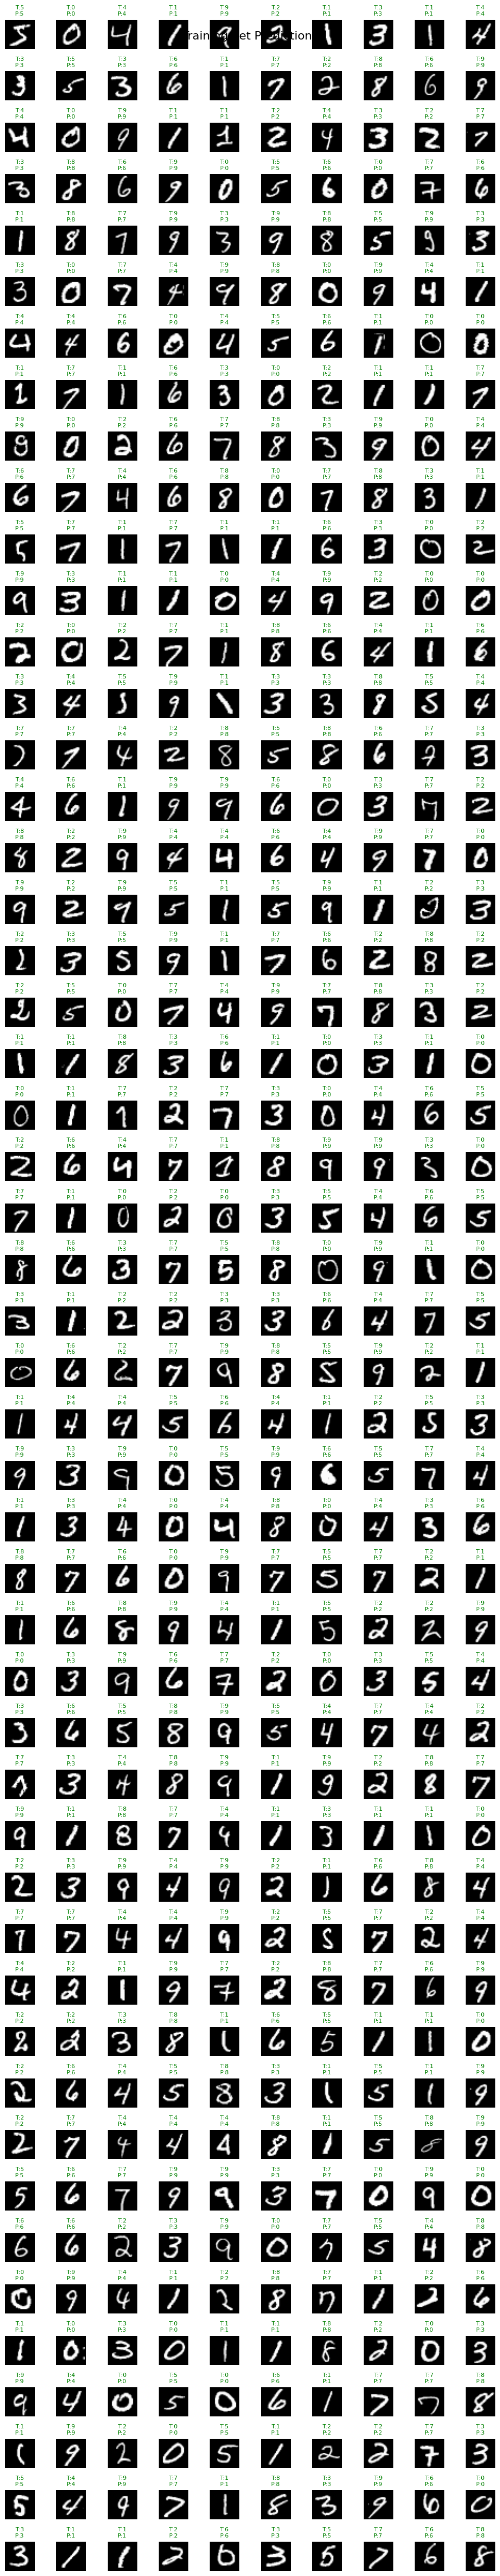

In [47]:

# Generate predictions on the training set
logits_train = state.apply_fn(state.params, x_train)
y_train_pred = jnp.argmax(logits_train, axis=-1)


# Convert to numpy arrays for plotting.
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
y_train_pred_np = np.array(y_train_pred)


# Plot some training examples.
plot_examples(x_train_np, y_train_np, y_train_pred_np, title="Training Set Predictions", n_cols=10)


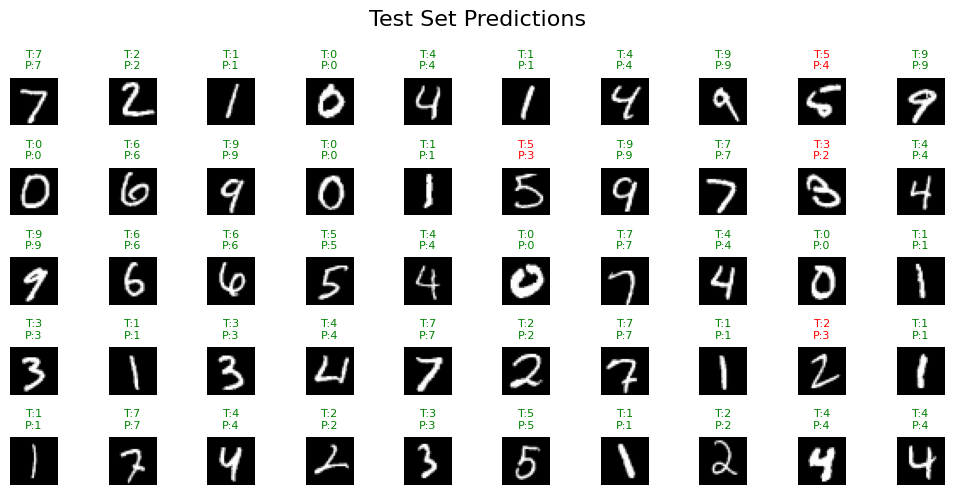

In [48]:
# Generate predictions on the test set
logits_test = state.apply_fn(state.params, x_test)
y_test_pred = jnp.argmax(logits_test, axis=-1)


x_test_np = np.array(x_test)
y_test_np = np.array(y_test)
y_test_pred_np = np.array(y_test_pred)

# Plot some test examples.
plot_examples(x_test_np, y_test_np, y_test_pred_np, title="Test Set Predictions", n_cols=10)

In [50]:
def compute_hvp(total_loss, flat_params, v):
    """
    Computes the Hessian-vector product: H v,
    where H = ∇²(total_loss) at flat_params.
    """
    return jax.jvp(jax.grad(total_loss), (flat_params,), (v,))[1]

def cg_solve_fori(hvp_fn, b, max_iter=100):
    """
    Conjugate gradient solver to solve hvp_fn(x) = b for x.
    Runs for fixed number of iterations using fori_loop.
    
    hvp_fn: function that computes H v given v.
    b: right-hand side vector.
    max_iter: fixed number of iterations to run
    """
    x = jnp.zeros_like(b)
    r = b - hvp_fn(x)
    p = r
    rsold = jnp.dot(r, r)
    
    def body_fn(i, state):
        x, r, p, rsold = state
        Ap = hvp_fn(p)
        alpha = rsold / jnp.dot(p, Ap)
        x_new = x + alpha * p
        r_new = r - alpha * Ap
        rsnew = jnp.dot(r_new, r_new)
        p_new = r_new + (rsnew / rsold) * p
        return (x_new, r_new, p_new, rsnew)
    
    init_state = (x, r, p, rsold)
    x, r, p, rsold = jax.lax.fori_loop(0, max_iter, body_fn, init_state)
    return x

# ---------------------------
# 4. Compute Influence Using HVPs and CG Solver
# ---------------------------
def compute_influences_cg(state, x_train_subset, y_train_subset, x_test, y_test, tol=1e-5, max_iter=100):
    # Flatten the parameters.
    flat_params, unravel_fn = ravel_pytree(state.params)
    
    # Define total_loss on the training subset.
    def total_loss(flat_params):
        params = unravel_fn(flat_params)
        return loss_fn(params, state.apply_fn, x_train_subset, y_train_subset)
    
    # Define a function that returns the HVP for any vector v.
    def hvp_fn(v):
        return compute_hvp(total_loss, flat_params, v)
    
    # Compute the gradient for the test example.
    grad_test = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_test, y_test))(state.params)
    flat_grad_test, _ = ravel_pytree(grad_test)
    
    influences = []
    # Compute influence for each training example in the subset.
    for i in tqdm(range(x_train_subset.shape[0]), desc="Computing influences"):
        x_i = x_train_subset[i:i+1]
        y_i = y_train_subset[i:i+1]
        grad_train = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_i, y_i))(state.params)
        flat_grad_train, _ = ravel_pytree(grad_train)
        # Solve H * x = flat_grad_train using CG to obtain x = H^{-1} flat_grad_train.
        hvp_inv_grad_train = cg_solve_fori(hvp_fn, flat_grad_train, max_iter=max_iter)
        # Influence: - (grad_test)^T * H^{-1} * (grad_train)
        infl = -jnp.dot(flat_grad_test, hvp_inv_grad_train)
        influences.append(infl)
    return jnp.array(influences)


 # For influence analysis, use a small training subset (e.g., 10 examples).
x_train_subset = x_train[:100]
y_train_subset = y_train[:100]

# Choose one test example.
index = 3 #  this gets a zero!
x_test_sample = x_test[index:index+1]
y_test_sample = y_test[index:index+1]

print("\nTest example:", y_test_sample)

# Compute influences using our CG-based approach.
influences = compute_influences_cg(state, x_train_subset, y_train_subset, x_test_sample, y_test_sample)

# Sort by absolute influence.
influences_np = np.array(influences)
sorted_indices = np.argsort(np.abs(influences_np))[::-1]

print("\nTop influential training examples (for the subset of 10 examples):")
for i in range(len(sorted_indices)):
    idx = sorted_indices[i]
    print(f"Training sample {idx}: Influence = {influences_np[idx]:.6f}")



Test example: [0]


Computing influences: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


Top influential training examples (for the subset of 10 examples):
Training sample 22: Influence = -0.525677
Training sample 99: Influence = 0.467323
Training sample 68: Influence = 0.438809
Training sample 50: Influence = -0.398128
Training sample 48: Influence = 0.312045
Training sample 93: Influence = -0.297391
Training sample 60: Influence = -0.196740
Training sample 24: Influence = 0.163299
Training sample 10: Influence = 0.161117
Training sample 81: Influence = -0.106264
Training sample 14: Influence = -0.090345
Training sample 69: Influence = 0.059248
Training sample 65: Influence = 0.051119
Training sample 16: Influence = -0.035831
Training sample 83: Influence = -0.029252
Training sample 87: Influence = -0.026736
Training sample 29: Influence = -0.024396
Training sample 54: Influence = 0.024035
Training sample 85: Influence = 0.023503
Training sample 56: Influence = -0.022606
Training sample 53: Influence = -0.022093
Training sample 59: Influence = 0.019541
Training sample 98

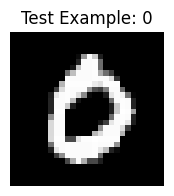

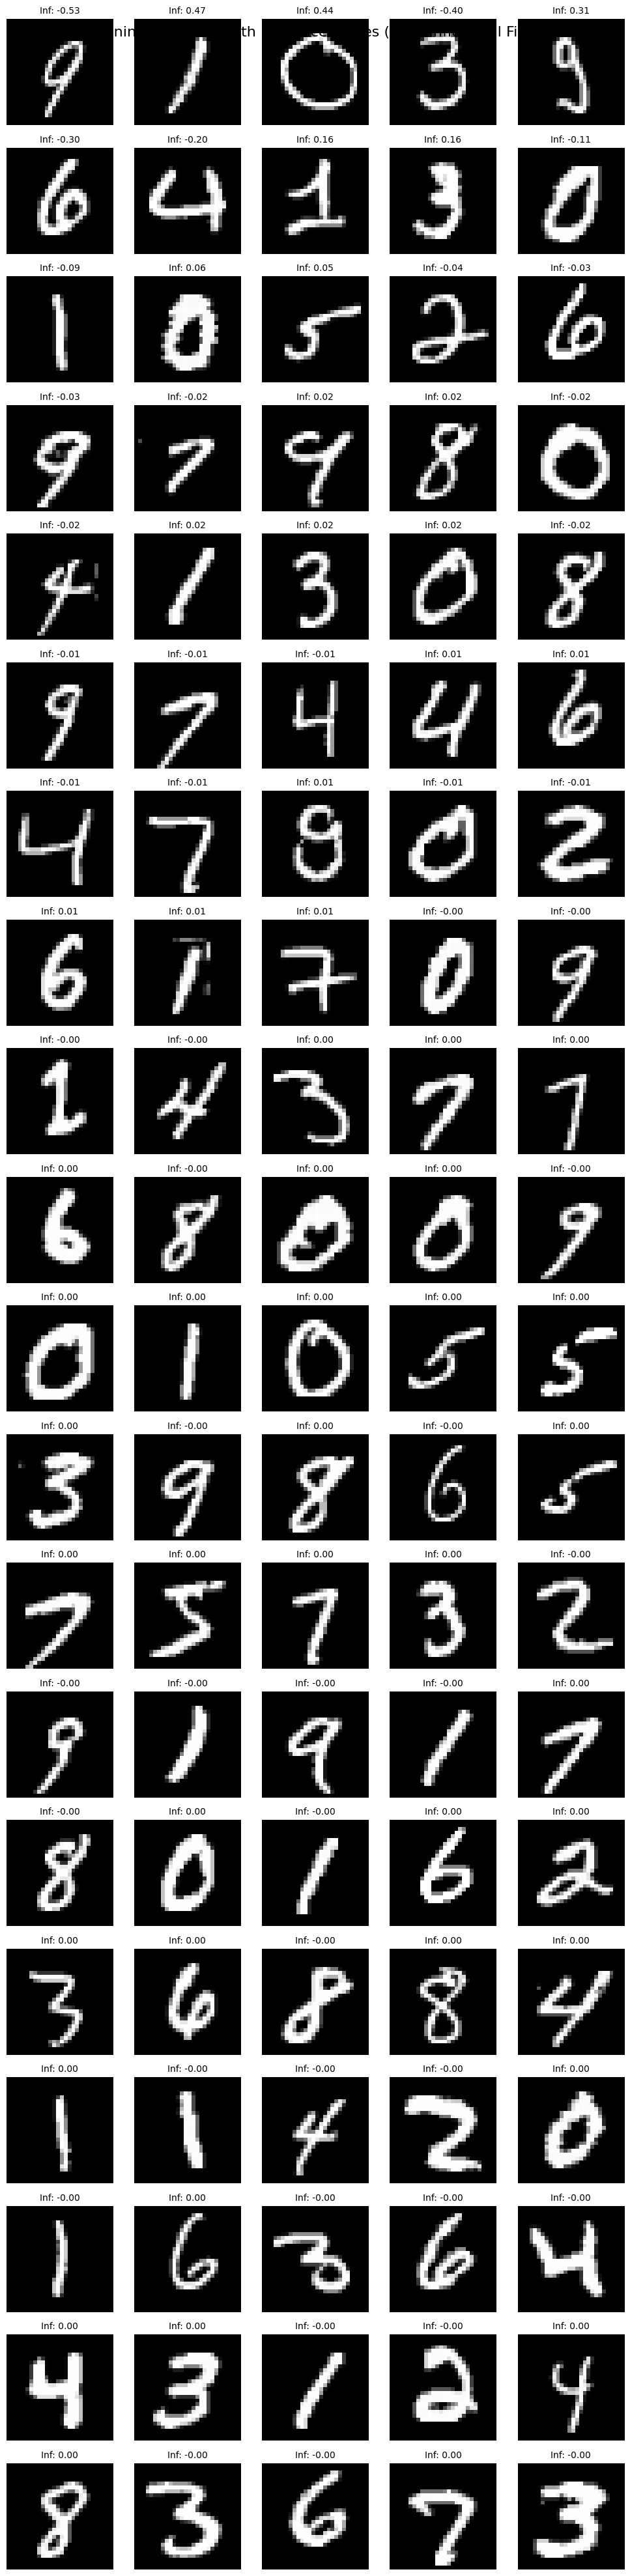

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_influential_examples(x_train_subset, influences, sorted_indices, n_cols=5):
    """
    Plots the training images (from the subset) sorted by influence (most influential first)
    in a grid layout. Influence values are displayed above each image.
    
    Parameters:
      - x_train_subset: NumPy array of training images (shape: [n_examples, 784])
      - influences: NumPy array of influence values (shape: [n_examples])
      - sorted_indices: Array of indices that sorts the influences by absolute value (descending)
      - n_cols: Number of columns in the grid (default 5)
    """
    # Reorder the training examples and influences according to sorted_indices.
    sorted_x = x_train_subset[sorted_indices]
    sorted_inf = influences[sorted_indices]
    
    n = sorted_x.shape[0]
    n_rows = (n + n_cols - 1) // n_cols  # Compute number of rows needed.
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    fig.suptitle("Training Examples with Influence Values (Most Influential First)", fontsize=16)
    
    # Flatten axs for easy iteration in case of multiple rows.
    axs = axs.flatten() if n > 1 else [axs]
    
    for i in range(n):
        ax = axs[i]
        # Reshape the flattened image to 28x28.
        image = sorted_x[i].reshape(28, 28)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Inf: {sorted_inf[i]:.2f}", fontsize=10)
    
    # Hide any extra subplots.
    for j in range(n, len(axs)):
        axs[j].axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_test_example(x_test_sample, y_test_sample):
    """Displays the test example."""
    image = np.array(x_test_sample[0]).reshape(28, 28)
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap="gray")
    plt.title(f"Test Example: {int(y_test_sample[0])}")
    plt.axis("off")
    plt.show()

# First, plot the test example.
plot_test_example(x_test_sample, y_test_sample)

# Then, plot the training examples sorted by influence.
# (Make sure x_train_subset and influences are numpy arrays.)
sorted_indices = np.argsort(np.abs(np.array(influences)))[::-1]
plot_influential_examples(np.array(x_train_subset), np.array(influences), sorted_indices, n_cols=5)


In [42]:
# --- Visualization ---
# Plot the original candidate and the optimized synthetic training example, along with the test example.
def plot_image(x, title):
    plt.figure(figsize=(2,2))
    plt.imshow(np.array(x).reshape(28,28), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------
# 4. Compute Influence for a Candidate Example
# ---------------------------
def influence_for_example(x_candidate, y_candidate, state, flat_params, hvp_fn, flat_grad_test):
    """
    Given a candidate training example (x_candidate, y_candidate), compute its influence:
      I(x_candidate) = - (grad_test)^T * H^{-1} * (∇_θ L(x_candidate, y_candidate)).
    
    Here x_candidate is made explicit in the differentiation.
    """
    # Define a function of x that computes the gradient (w.r.t. parameters).
    def grad_wrt_params(x):
        return jax.grad(lambda params: loss_fn(params, state.apply_fn, x, y_candidate))(state.params)
    
    grad_train = grad_wrt_params(x_candidate)
    flat_grad_train, _ = ravel_pytree(grad_train)
    # Use the static CG solver.
    hvp_inv_grad_train = cg_solve_fori(hvp_fn, flat_grad_train, max_iter=100)
    influence = -jnp.dot(flat_grad_test, hvp_inv_grad_train)
    return influence

# ---------------------------
# 5. Adversarial-Style Synthetic Example Optimization
# ---------------------------
def optimize_synthetic_example_adv(state, y_syn, x_init, 
                                   x_train_subset, y_train_subset, 
                                   x_test, y_test,
                                   lr=0.01, num_steps=100, momentum=0.9):
    """
    Uses an adversarial-attack–style update with momentum to optimize a candidate training example x (starting from x_init)
    so that its influence on the given test example is maximized in a beneficial (negative) direction.
    """
    # Flatten model parameters and define total_loss on the training subset.
    flat_params, unravel_fn = ravel_pytree(state.params)
    def total_loss(flat_params):
        params = unravel_fn(flat_params)
        return loss_fn(params, state.apply_fn, x_train_subset, y_train_subset)
    
    def hvp_fn(v):
        return compute_hvp(total_loss, flat_params, v)
    
    # Compute the gradient for the test example.
    grad_test = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_test, y_test))(state.params)
    flat_grad_test, _ = ravel_pytree(grad_test)
    
    # Define candidate influence as a function of x_candidate.
    def influence_candidate(x):
        x = jnp.reshape(x, (1, -1))
        grad_train = jax.grad(lambda params: loss_fn(params, state.apply_fn, x, y_syn))(state.params)
        flat_grad_train, _ = ravel_pytree(grad_train)
        hvp_inv_grad_train = cg_solve_fori(hvp_fn, flat_grad_train, max_iter=100)
        return -jnp.dot(flat_grad_test, hvp_inv_grad_train)
    
    # Initialize candidate and velocity.
    x_candidate = x_init
    v = jnp.zeros_like(x_candidate)
    plot_image(x_candidate, "Step 0")
    
    for i in range(num_steps):
        inf_val, grad_x = jax.value_and_grad(influence_candidate)(x_candidate)
        # Normalize the gradient.
        grad_norm = jnp.linalg.norm(grad_x) + 1e-8
        normalized_grad = grad_x / grad_norm
        
        # Update the velocity with momentum.
        v = momentum * v + normalized_grad
        
        # Adversarial update with momentum.
        x_candidate = x_candidate - lr * v
        
        # Project back to [0,1].
        x_candidate = jnp.clip(x_candidate, 0.0, 1.0)
        
        if i % 10 == 0:
            print(f"Step {i}: Influence = {inf_val:.4f}")
            plot_image(x_candidate, f"Step {i}")
    
    return x_candidate, influence_candidate(x_candidate)


0

Optimizing synthetic training example...


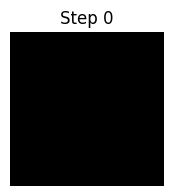

Step 0: Influence = 1724992323584.0000


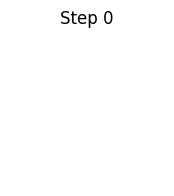

Step 10: Influence = nan


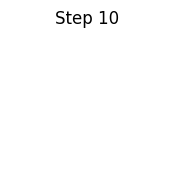

KeyboardInterrupt: 

In [60]:
# Flatten the parameters.
flat_params, unravel_fn = ravel_pytree(state.params)

# Define total_loss on the subset.
def total_loss(flat_params):
    params = unravel_fn(flat_params)
    return loss_fn(params, state.apply_fn, x_train_subset, y_train_subset)

# Define hvp_fn using the subset.
def hvp_fn(v):
    return compute_hvp(total_loss, flat_params, v)


# Compute gradient for the test example.
index = 3
x_test_sample = x_test[index:index+1]
y_test_sample = y_test[index:index+1]

grad_test = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_test_sample, y_test_sample))(state.params)
flat_grad_test, _ = ravel_pytree(grad_test)


# --- Synthetic Example Optimization ---
# We choose a candidate initialization. For example, we can start from the average image
# of all training examples with the same label as the test sample.
test_label = y_test_sample[0]

print(test_label)
matching = (y_train == test_label)
if matching.sum() > 0:
    x_init = jnp.mean(x_train[matching], axis=0, keepdims=True)
else:
    x_init = jnp.mean(x_train, axis=0, keepdims=True)

# key = jax.random.PRNGKey(42)
# x_init = jax.random.uniform(key, shape=(1, 784), minval=0.0, maxval=1.0)


x_init = jax.random.uniform(key, shape=(1, 784), minval=0.5, maxval=0.5)


# Optimize the candidate training example.
print("\nOptimizing synthetic training example...")
x_synth, final_influence = optimize_synthetic_example_adv(state, test_label, x_init, 
                                                               x_train_subset, y_train_subset,
                                                               x_test_sample, y_test_sample,
                                                               lr=0.1, num_steps=500)
print(f"Final influence: {final_influence:.4f}")
    


plot_image(x_init, f"Initial Candidate (Label: {int(test_label)})")
plot_image(x_synth, f"Optimized Synthetic Example\nInfluence: {final_influence:.2f}")
plot_image(x_test_sample, f"Test Example (Label: {int(y_test_sample[0])})")
